<a href="https://colab.research.google.com/github/MiguelRochaBE/MotorImagery-BCI/blob/master/Optimized_DB_Analysis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True) 

# Doxygen para documentar o codigo

## **Paths dos dados**

In [ ]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles

subfolders, datafiles = run_fast_scandir('C:\\Users\\migue\\OneDrive\\Ambiente de Trabalho\\EEG stuff\\Motor Imagery\\files', [".edf"])

In [ ]:

import mne
import numpy as np

In [ ]:
min_freq = 4
max_freq = 40

n_bands = int((max_freq - min_freq)/2)

bands = []
f1 = 4
f2 = 8

for i in range(1,n_bands):
  bands.append([f1,f2])
  f1+=2
  f2+=2
print("Bandas de frequência: ", bands)

Bandas de frequência:  [[4, 8], [6, 10], [8, 12], [10, 14], [12, 16], [14, 18], [16, 20], [18, 22], [20, 24], [22, 26], [24, 28], [26, 30], [28, 32], [30, 34], [32, 36], [34, 38], [36, 40]]


## **Leitura dos dados**

In [ ]:
mne.set_log_level('WARNING') #  Suprimir os logs das funções da biblioteca/ it can be either DEBUG, INFO, WARNING, ERROR, or CRITICAL

filter_design = 'firwin2'
ska = 'edge'

raw = mne.io.read_raw_edf(datafiles[0], preload = False)
channels = raw.ch_names
n_channels = len(channels)

for band in bands:

  filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],l_freq=band[0], h_freq=band[1], fir_design = filter_design) # Criar filtro. É preciso dados como parâmetro
  #mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(0.5, 60)) # Plot do filtro

In [ ]:
def load_subject_data(subject, datafiles, bands):

  trials = []
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)

  eachBand_epochs = []
  
  for band in bands: # Filtrar os dados nas várias bandas de frequência
    print(f"Filtragem na banda de frequências: {band[0]} - {band[1]} Hz")

    all_trials = [] # Variável com todos os blocos
    
    for count, trial  in enumerate(trials):
      if count > 1: # Avança os dois primeiros trials correspondentes ao rest
        raw_data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório
        
        ch_names = raw_data.ch_names # Elétrodos
        fs =  raw_data.info.get('sfreq') # Frequência de amostragem
        annotations = raw_data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados

        trial_type1 = [3, 4, 7, 8, 11, 12]
        trial_type2 = [5, 6, 9, 10, 13, 14]

        # Atribuição das labels corretas aos eventos de cada trial

        trial_number = int(trial.split('.')[0][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
        
        if trial_number in trial_type1:
          event_ids = {'T0': 1, 'T1': 2, 'T2': 3} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
          epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "right_fist/block": 3}
        elif trial_number in trial_type2:
          event_ids = {'T0': 1, 'T1': 4, 'T2': 5}
          epoch_event_ids = {"rest/block": 1, "both_fists/block": 4,"both_feet/block": 5}
        else:
          event_ids = {'T0': 1} # Dois primeiros trials de EEG
          epoch_event_ids = {"rest/block": 1}
          
        # Filtragem

        filtered_data = raw_data.copy().filter(band[0], band[1], fir_design=filter_design, skip_by_annotation=ska) 
        
        # Mapeamento dos eventos com as novas labels

        events = mne.events_from_annotations(filtered_data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
        
        # Agrupamento dos blocos do mesmo id (epoching)

        tstart = 0.5
        tstop = 3
        epochs = mne.Epochs(filtered_data, events[0], event_id = epoch_event_ids, tmin = tstart, tmax = tstop, detrend = 1, baseline = None, preload = True)
        
        all_trials.append(epochs)
        
    # Concatenação de todos os blocos (trials) de uma banda de frequências

    subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')
    equalized_subject_epochs = subject_epochs.equalize_event_counts()[0]

    eachBand_epochs.append(equalized_subject_epochs)
    
  return eachBand_epochs

## **Train/Test split**

In [ ]:
def split_EEG(subject_EEG, classes, percent_train=0.8):
  
  n_trials, _, _ = np.shape(subject_EEG)
  n_train = round((n_trials/len(classes)) * percent_train)
  n_test = int((n_trials/len(classes)) - n_train)

  #print("Nº de trials: ", n_trials)
  #print("Nº de trials para treinar (por classe): ", n_train)
  #print("Nº de trials para teste (por classe): ", n_test)

  epochs_train = []
  epochs_test = []

  for class_key, _ in classes.items():
    epochs_train.append(subject_EEG[class_key][:n_train])
    epochs_test.append(subject_EEG[class_key][n_train:n_train+n_test])
  
  epochs_train = mne.concatenate_epochs(epochs_train, add_offset = True, on_mismatch = 'raise')
  epochs_test = mne.concatenate_epochs(epochs_test, add_offset = True, on_mismatch = 'raise')

  return epochs_train, epochs_test

## **CSP**

In [ ]:
import numpy as np
from numpy import linalg
from scipy.linalg import sqrtm
from scipy.linalg import inv

# Matrizes das covariâncias:

def covariances(epoched_data):

  '''
  Cálculo das matrizes de covariância para cada classe
  '''

  classes = epoched_data.event_id
  n_trials, n_channels, n_samples = np.shape(epoched_data)
  n_trials = int(n_trials/len(classes))
  Trials_convs = np.zeros((n_trials, n_channels, n_channels))
  Class_convs = np.zeros((len(classes), n_channels, n_channels)) 
  # Pré alocação da variável 'convs'. Isto é boa prática fazer antes de qualquer ciclo para reduzir o tempo de processamento pré-alocando o array na memória.
  
  for mi_class, id in classes.items(): # Iteração de um dicionário
  
    Xc = epoched_data[mi_class].get_data()
    for trial in range(n_trials):
      Trials_convs[trial,:,:] = (Xc[trial,:,:] @ Xc[trial,:,:].T) / (np.trace (Xc[trial,:,:] @ Xc[trial,:,:].T)) # Cálculo das Covariâncias com normalização ap aprtir do traço da matriz
    Class_convs[id-1,:,:] = np.mean(Trials_convs, axis = 0) # Média dos trials da mesma classe
    
  return Class_convs

# Whitening da matriz, ou seja, transformação que permite com que a matriz tenha a mesma covariância da matriz Identidade (I), 
# logo covariâncias de 0 entre todos os pares:

def decompose_cov(avg_cov):

    λ, V = np.linalg.eig(avg_cov) # λ são o eigenvalues e V os eigenvectors
    λ_desc = np.sort(λ)[::-1] 
    idx_desc = np.argsort(λ)[::-1] 
    V_desc = V[:, idx_desc] 
    λ_desc = np.diag(λ_desc) 
    
    return λ_desc, V_desc

def whitening(λ_desc, V_desc):

    λ_desc_sqr = sqrtm(inv(λ_desc))
    P = (λ_desc_sqr) @ (V_desc.T)
    
    return P

# Matriz S que contém os eigenvectors que maximizam a variância do EEG (freq) numa classe e minimiza noutra:

def compute_S(avg_Cov, white):
    
    S = white @ avg_Cov @ white.T
 
    return S

def decompose_S(S_one_class, order='d'):
  
    λ, B = np.linalg.eig(S_one_class)
    
    if order == 'a': # ascending
        idx = λ.argsort() 
    elif order == 'd': # descending
        idx = λ.argsort()[::-1] 
    else:
        print('Wrong order input')
    
    λ = λ[idx]
    B = B[:, idx]
    
    return B, λ 

# Filtro espacial (Matriz de projeção):

  # B_one_class = np.zeros( (len(classes),len(subject_epochs.get_channel_types())) )
  # B_the_rest_classes = np.zeros( (len(classes),len(subject_epochs.get_channel_types())) )

def spatial_filter(B, P):

    return (B.T @ P)

def spatially_filter_EEG(W, EEG, n_comp):

    Z = []
    
    W = np.delete(W, np.s_[n_comp:-n_comp:], 0)

    for trial in range(len(EEG.events)):
      Z.append( W @ np.squeeze(EEG[trial].get_data()) )

    return np.array(Z)

def feat_vector(Z):
    
    feat = []
    
    for i in range(Z.shape[0]):
        var = np.var(Z[i], ddof=1, axis=1)
        varsum = np.sum(var)
        
        feat.append(np.log10(var/varsum))
        
    return np.array(feat)

def spatially_filter_EEG(W, EEG, n_comp):

    Z = []
    
    W = np.delete(W, np.s_[n_comp:-n_comp:], 0)

    for trial in range(len(EEG.events)):
      Z.append( W @ np.squeeze(EEG[trial].get_data()) )

    return np.array(Z)

def feat_vector(Z):
    
    feat = []
    
    for i in range(Z.shape[0]):
        var = np.var(Z[i], ddof=1, axis=1)
        varsum = np.sum(var)
        
        feat.append(np.log10(var/varsum))
        
    return np.array(feat)

In [ ]:
mne.set_log_level('CRITICAL')

perSubj_train_feat_vect = []
perSubj_test_feat_vect = []

all_train_labels = []
all_test_labels = []

all_comp = np.arange(1,19) # De 1 a 18

''' for id, subject in enumerate(subfolders): '''

for id, subject in enumerate(subfolders):

  print("---------------------------------------------")
  print("1º - Ler e filtrar dados do participante: ", id+1)

  subject_epochs = load_subject_data(subject, datafiles, bands)

  if(id == 0):
      classes = subject_epochs[0].event_id

  perComp_train_feat_vect = []
  perComp_test_feat_vect =[]

  perComp_train_labels = []
  perComp_test_labels = []

  for _, n_comp in enumerate(all_comp):

    print("----------------------")
    print("Compomentes do CSP: ", n_comp)

    perBand_train_feat_vect = []
    perBand_test_feat_vect =[]

    train_labels = []
    test_labels = []

    for band in range(len(bands)):

      if band == 0:
        print("2ª - Train/Test split")

      train_data, test_data = split_EEG(subject_epochs[band], classes, percent_train=0.8)

      train_labels.append(train_data.events[:,2])
      test_labels.append(test_data.events[:,2])

      if band == 0:
        print("3º - Obtenção da matriz W")

      Class_convs = covariances(train_data)
      Avg_convs = Class_convs.sum(axis = 0)
      λ_desc, V_desc = decompose_cov(Avg_convs)
      P = whitening(λ_desc, V_desc)
      W = np.zeros( (len(classes), n_channels, n_channels) )

      for _, id in classes.items(): 
        
        one = compute_S(Class_convs[id-1,:,:], P)
        the_rest = compute_S(  np.sum(Class_convs[:(id-1),:,:], axis = 0) + np.sum(Class_convs[id:,:,:], axis = 0)  , P)

        λ_one, B_one = decompose_S(one, 'd')
        λ_the_rest, B_the_rest = decompose_S(the_rest, 'a')
        
        W[id-1,:,:] = spatial_filter(λ_one, P) 

      train_feat_vect = []
      test_feat_vect = []

      if band == 0:
        print("4º - Filtragem espacial do sinal com a matriz W do CSP")

      for mi_class, c_id in classes.items():

        Z_aux_train = spatially_filter_EEG(W[c_id-1,:,:], train_data[mi_class], n_comp)
        train_feat_vect.append(feat_vector(Z_aux_train))

        Z_aux_test = spatially_filter_EEG(W[c_id-1,:,:], test_data[mi_class], n_comp)
        test_feat_vect.append(feat_vector(Z_aux_test))

      perBand_train_feat_vect.append(train_feat_vect)
      perBand_test_feat_vect.append(test_feat_vect)

    perComp_train_feat_vect.append(perBand_train_feat_vect)
    perComp_test_feat_vect.append(perBand_test_feat_vect)

    perComp_train_labels.append(train_labels)
    perComp_test_labels.append(test_labels)

  perSubj_train_feat_vect.append(perComp_train_feat_vect)
  perSubj_test_feat_vect.append(perComp_test_feat_vect)

  all_train_labels.append(perComp_train_labels)
  all_test_labels.append(perComp_test_labels)

---------------------------------------------
1º - Ler e filtrar dados do participante:  1
Filtragem na banda de frequências: 4 - 8 Hz
Filtragem na banda de frequências: 6 - 10 Hz
Filtragem na banda de frequências: 8 - 12 Hz
Filtragem na banda de frequências: 10 - 14 Hz
Filtragem na banda de frequências: 12 - 16 Hz
Filtragem na banda de frequências: 14 - 18 Hz
Filtragem na banda de frequências: 16 - 20 Hz
Filtragem na banda de frequências: 18 - 22 Hz
Filtragem na banda de frequências: 20 - 24 Hz
Filtragem na banda de frequências: 22 - 26 Hz
Filtragem na banda de frequências: 24 - 28 Hz
Filtragem na banda de frequências: 26 - 30 Hz
Filtragem na banda de frequências: 28 - 32 Hz
Filtragem na banda de frequências: 30 - 34 Hz
Filtragem na banda de frequências: 32 - 36 Hz
Filtragem na banda de frequências: 34 - 38 Hz
Filtragem na banda de frequências: 36 - 40 Hz
----------------------
Compomentes do CSP:  1
2ª - Train/Test split
3º - Obtenção da matriz W
4º - Filtragem espacial do sinal com 

## **Guardas/Importar variáveis**

In [ ]:
np.save('perSubj_train_feat_vect.npy', perSubj_train_feat_vect)
np.save('perSubj_test_feat_vect.npy', perSubj_test_feat_vect)

np.save('all_train_labels.npy', all_train_labels)
np.save('all_test_labels.npy', all_test_labels)

c:\Users\migue\anaconda3\envs\BCI\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
perSubj_train_feat_vect1 = np.load('perSubj_train_feat_vect.npy', allow_pickle = True)
perSubj_test_feat_vect1 = np.load('perSubj_test_feat_vect.npy', allow_pickle = True)

all_train_labels1 = np.load('all_train_labels.npy', allow_pickle = True)
all_test_labels1 = np.load('all_test_labels.npy', allow_pickle = True)

## **Seleção da banda mais discriminativa**

### **Concatenar os dados das várias bandas de frequência horizontalmente (Por colunas)**

In [ ]:
conc_all_comp_feat_classes_train = []
conc_all_comp_feat_classes_test = []

for subject in range(len(perSubj_train_feat_vect)):
  aux3_train = []
  aux3_test = []
  for count, n_conp in enumerate(all_comp):
    aux2_train = []
    aux2_test = []
    for _, c_id in classes.items():
      for band in range(1,len(bands)):
        if band == 1:
          aux1_train = np.hstack((perSubj_train_feat_vect[subject][count][band-1][c_id-1], perSubj_train_feat_vect[subject][count][band][c_id-1]))
          aux1_test = np.hstack((perSubj_test_feat_vect[subject][count][band-1][c_id-1], perSubj_test_feat_vect[subject][count][band][c_id-1]))
        else:
          aux1_train = np.hstack((aux1_train,perSubj_train_feat_vect[subject][count][band][c_id-1]))
          aux1_test = np.hstack((aux1_test,perSubj_test_feat_vect[subject][count][band][c_id-1]))
      aux2_train.append(aux1_train)
      aux2_test.append(aux1_test)
    aux3_train.append(aux2_train)
    aux3_test.append(aux2_test)
  conc_all_comp_feat_classes_train.append(aux3_train)
  conc_all_comp_feat_classes_test.append(aux3_test)

### **Mutual Based Information (MI)**

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

all_subject_comp_fselect_train = []
all_subject_comp_fselect_test = []
all_idx = []

k_feat = 34

for subject in range(len(perSubj_train_feat_vect)):

  comp_fselect_train = []
  comp_fselect_test = []
  idx = []

  for count, n_comp in enumerate(all_comp):
    for c_id in range(1,len(classes)):
      if (c_id) == 1:
        X_train = np.vstack((conc_all_comp_feat_classes_train[subject][count][c_id-1],conc_all_comp_feat_classes_train[subject][count][c_id]))
        X_test = np.vstack((conc_all_comp_feat_classes_test[subject][count][c_id-1],conc_all_comp_feat_classes_test[subject][count][c_id]))
      else:
        X_train = np.vstack((X_train, conc_all_comp_feat_classes_train[subject][count][c_id]))
        X_test = np.vstack((X_test, conc_all_comp_feat_classes_test[subject][count][c_id]))

    y_train = all_train_labels[subject][count][0].reshape(-1,1)

    train = np.concatenate((X_train,y_train), axis = 1)
    np.random.shuffle(train)

    _, n = np.shape(train) 
    subj_feat = SelectKBest(mutual_info_classif, k = k_feat).fit(train[:,0:(n-1)], train[:,(n-1)])
    idx.append(subj_feat.get_support())

    comp_fselect_train.append(np.concatenate((X_train[:,idx[count]], y_train.reshape(-1,1)), axis = 1))
    comp_fselect_test.append(X_test[:,idx[count]])

  all_subject_comp_fselect_train.append(comp_fselect_train)
  all_subject_comp_fselect_test.append(comp_fselect_test)
  all_idx.append(idx)

## **Classificação multiclasses com um classificador**

### **LDA - Treino**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score

clf = LDA(solver = 'svd')
kfold = 10

np.random.seed()

all_cross_val_scores = np.zeros((len(all_comp), len(perSubj_train_feat_vect),2))
mean_cross_val_scores = np.zeros((len(all_comp),2))

all_shuffled_test_labels = []
all_test = []

for count, n_comp in enumerate(all_comp):

  cross_val_scores = np.zeros((len(perSubj_train_feat_vect),2))

  test_labels=[]
  test=[]

  for subject in range(len(perSubj_train_feat_vect)):

    X_train = all_subject_comp_fselect_train[subject][count][:, 0:k_feat]
    X_test = all_subject_comp_fselect_test[subject][count]

    y_train = all_subject_comp_fselect_train[subject][count][:, k_feat].reshape(-1,1)
    y_test = all_test_labels[subject][count][0].reshape(-1,1)

    train = np.concatenate((X_train,y_train), axis = 1)
    test.append(np.concatenate((X_test,y_test), axis = 1))

    np.random.shuffle(train) # Randomiza a ordem
    np.random.shuffle(test[subject])

    # Perform cross-validation on train data with LDA classifier (Tuning hyperparameters)
    scores = cross_val_score(clf, train[:,0:k_feat], train[:,k_feat], cv=kfold)

    # Fit the LDA classifier on the entire train dataset (Model training)
    clf.fit(train[:,0:k_feat], train[:,k_feat])

    # Predict the target classes for test dataset
    test_labels.append(clf.predict(test[subject][:,0:k_feat]))
  
    cross_val_scores[subject,0] = (scores.mean() * 100)
    cross_val_scores[subject,1] = (scores.std() * 100)

    #print("Acuracia (Cross-validation) do participante %d: %0.2f (+/- %0.2f)" % (subject+1, cross_val_scores[subject,0], cross_val_scores[subject,1]))

  #print("Média de acuracia (Cross-validation) com %d componentes: %0.2f (+/- %0.2f) " % (n_comp,np.mean(cross_val_scores[:,0]), np.mean(cross_val_scores[:,1])))

  all_cross_val_scores[count] = cross_val_scores

  all_test.append(test)
  all_shuffled_test_labels.append(test_labels)

  mean_cross_val_scores[count,0] = np.mean(cross_val_scores[:,0])
  mean_cross_val_scores[count,1] = np.mean(cross_val_scores[:,1])

In [ ]:
idx = np.argmax(mean_cross_val_scores[:,0]) # Indice da melhor acuracia
print(idx)

1


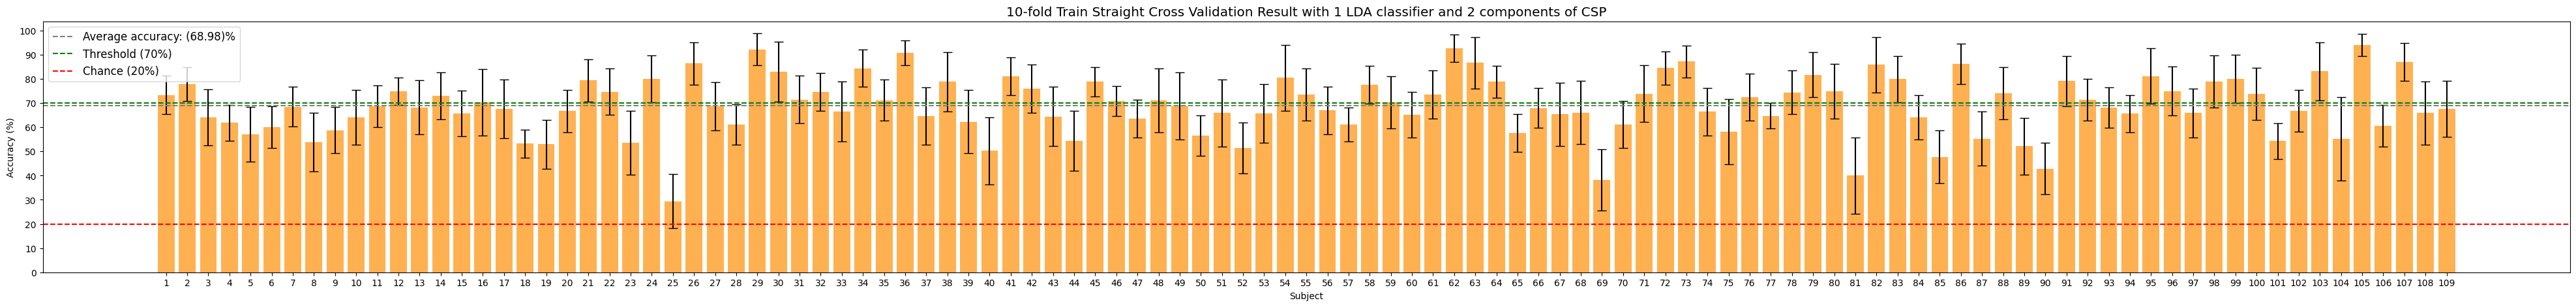

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(perSubj_train_feat_vect)+1), all_cross_val_scores[idx][:,0], color="#ffb152", yerr=all_cross_val_scores[idx][:,1], capsize=5)
ax.axhline(y=np.mean(all_cross_val_scores[idx][:,0]), color='grey', linestyle='--', label = f'Average accuracy: ({np.mean(all_cross_val_scores[idx][:,0]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(perSubj_train_feat_vect)+1), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'10-fold Train Straight Cross Validation Result with 1 LDA classifier and {idx+1} components of CSP');
ax.legend();

### **LDA - Teste**

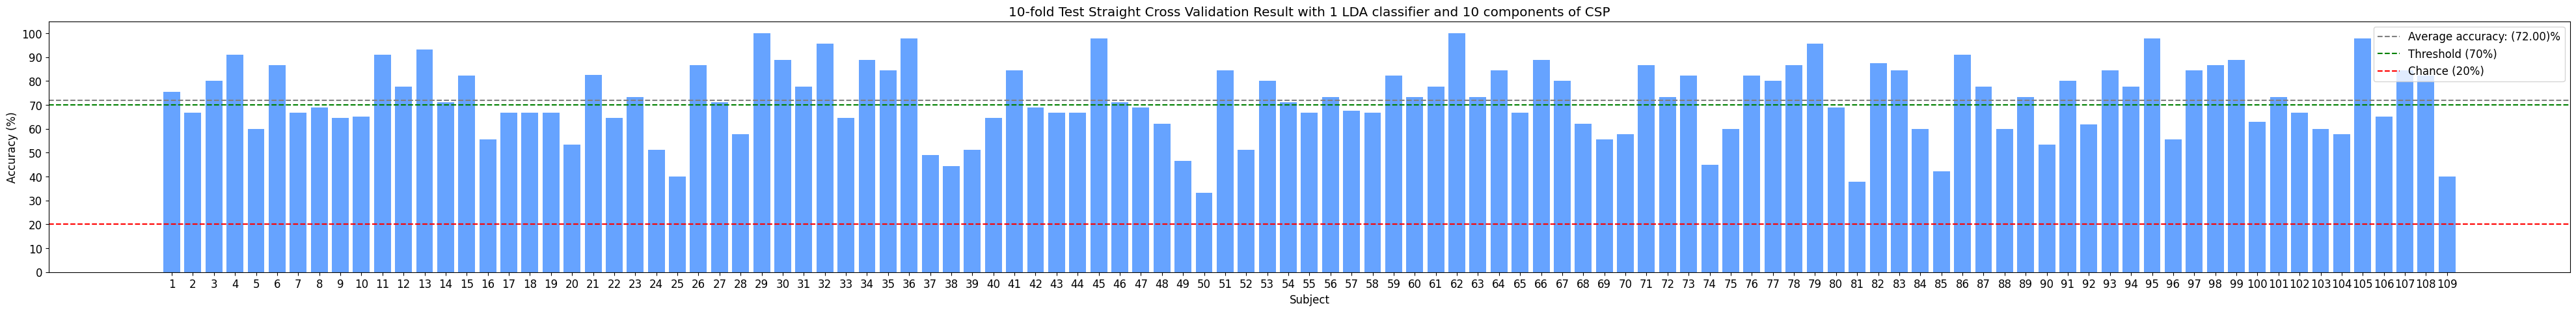

In [ ]:
from sklearn.metrics import accuracy_score

all_acc_comp = np.zeros((len(all_comp),len(perSubj_train_feat_vect)))
mean_acc = np.zeros((len(all_comp),1))

for count, n_comp in enumerate(all_comp):

  all_acc = np.zeros(len(perSubj_train_feat_vect))

  for subject in range(len(perSubj_train_feat_vect)):

    acc = accuracy_score(all_test[count][subject][:,k_feat],all_shuffled_test_labels[count][subject]) * 100
    all_acc[subject] = acc 

    #print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

  mean_acc[count] = np.mean(all_acc)
  all_acc_comp[count,:] = all_acc

idx = np.argmax(mean_acc) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(perSubj_train_feat_vect)+1), all_acc_comp[idx], color="#66a3ff", capsize=5)
ax.axhline(y=np.mean(all_acc_comp[idx]), color='grey', linestyle='--', label = f'Average accuracy: ({np.mean(all_acc_comp[idx]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(perSubj_train_feat_vect)+1), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'{kfold}-fold Test Straight Cross Validation Result with 1 LDA classifier and {idx+1} components of CSP');
ax.legend();

### **SVM - Treino**

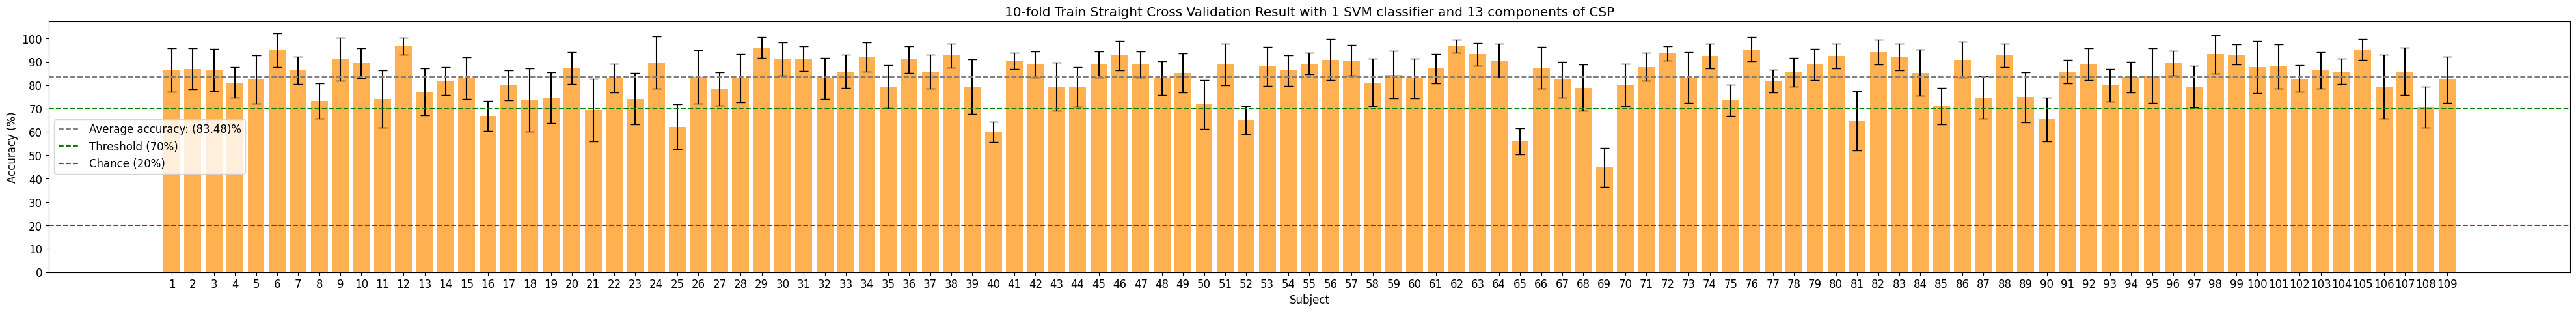

In [ ]:
from sklearn.svm import SVC

#clf = [SVC(kernel='rbf'), SVC(kernel='linear'), SVC(kernel='poly'), SVC(kernel='precomputed'), SVC(kernel='sigmoid'), LDA(), ]

clf = SVC(kernel='rbf')

kfold = 10

all_cross_val_scores = np.zeros((len(all_comp), len(perSubj_train_feat_vect),2))
mean_cross_val_scores = np.zeros((len(all_comp),2))

all_shuffled_test_labels = []
all_test = []

for count, n_comp in enumerate(all_comp):

  cross_val_scores = np.zeros((len(perSubj_train_feat_vect),2))

  test_labels=[]
  test=[]

  for subject in range(len(perSubj_train_feat_vect)):

    X_train = all_subject_comp_fselect_train[subject][count][:, 0:k_feat]
    X_test = all_subject_comp_fselect_test[subject][count]

    y_train = all_subject_comp_fselect_train[subject][count][:, k_feat].reshape(-1,1)
    y_test = all_test_labels[subject][count][0].reshape(-1,1)

    train = np.concatenate((X_train,y_train), axis = 1)
    test.append(np.concatenate((X_test,y_test), axis = 1))

    np.random.shuffle(train) # Randomiza a ordem
    np.random.shuffle(test[subject])

    # Perform cross-validation on train data with LDA classifier (Tuning hyperparameters)
    scores = cross_val_score(clf, train[:,0:k_feat], train[:,k_feat], cv=kfold)

    # Fit the LDA classifier on the entire train dataset (Model training)
    clf.fit(train[:,0:k_feat], train[:,k_feat])

    # Predict the target classes for test dataset
    test_labels.append(clf.predict(test[subject][:,0:k_feat]))
  
    cross_val_scores[subject,0] = (scores.mean() * 100)
    cross_val_scores[subject,1] = (scores.std() * 100)

    #print("Acuracia (Cross-validation) do participante %d: %0.2f (+/- %0.2f)" % (subject+1, cross_val_scores[subject,0], cross_val_scores[subject,1]))

  #print("Média de acuracia (Cross-validation) com %d componentes: %0.2f (+/- %0.2f) " % (n_comp,np.mean(cross_val_scores[:,0]), np.mean(cross_val_scores[:,1])))

  all_cross_val_scores[count] = cross_val_scores

  all_test.append(test)
  all_shuffled_test_labels.append(test_labels)

  mean_cross_val_scores[count,0] = np.mean(cross_val_scores[:,0])
  mean_cross_val_scores[count,1] = np.mean(cross_val_scores[:,1])

idx = np.argmax(mean_cross_val_scores[:,0]) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(perSubj_train_feat_vect)+1), all_cross_val_scores[idx][:,0], color="#ffb152", yerr=all_cross_val_scores[idx][:,1], capsize=5)
ax.axhline(y=np.mean(all_cross_val_scores[idx][:,0]), color='grey', linestyle='--', label = f'Average accuracy: ({np.mean(all_cross_val_scores[idx][:,0]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(perSubj_train_feat_vect)+1), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'{kfold}-fold Train Straight Cross Validation Result with 1 SVM classifier and {idx+1} components of CSP');
ax.legend();


### **SVM - Teste**

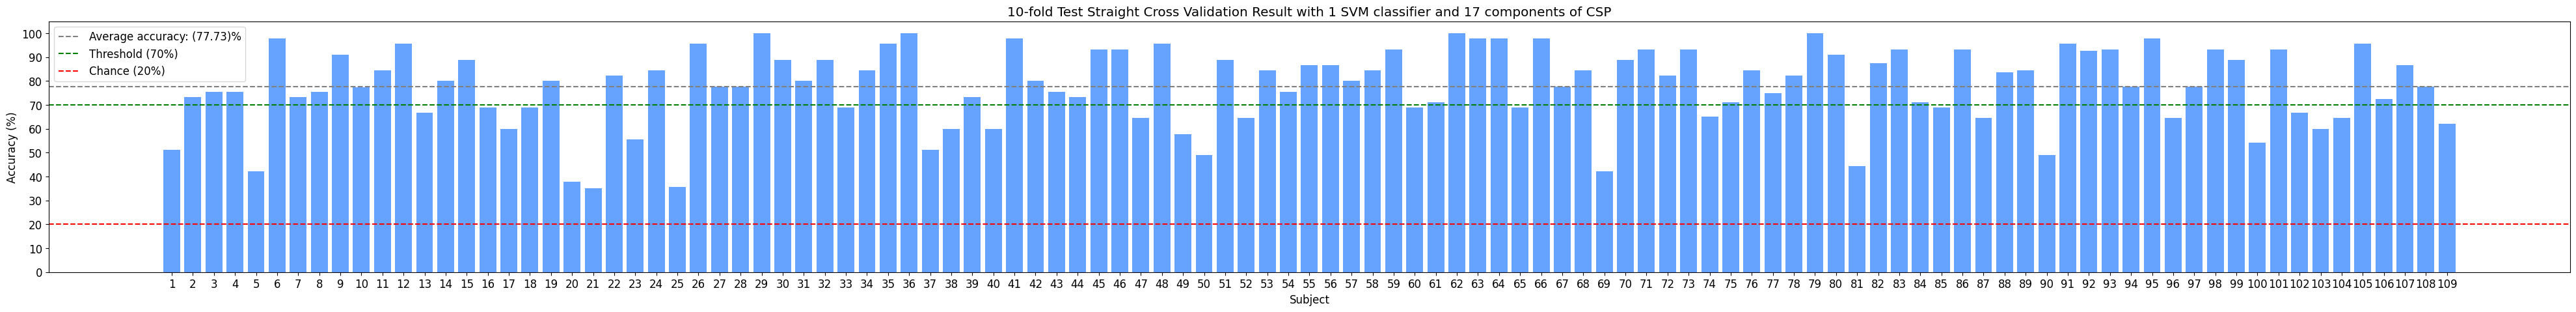

In [ ]:
all_acc_comp = np.zeros((len(all_comp),len(perSubj_train_feat_vect)))
mean_acc = np.zeros((len(all_comp),1))

for count, n_comp in enumerate(all_comp):

  all_acc = np.zeros(len(perSubj_train_feat_vect))

  for subject in range(len(perSubj_train_feat_vect)):

    acc = accuracy_score(all_test[count][subject][:,k_feat],all_shuffled_test_labels[count][subject]) * 100
    all_acc[subject] = acc 

    #print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

  mean_acc[count] = np.mean(all_acc)
  all_acc_comp[count,:] = all_acc

idx = np.argmax(mean_acc) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(perSubj_train_feat_vect)+1), all_acc_comp[idx], color="#66a3ff", capsize=5)
ax.axhline(y=np.mean(all_acc_comp[idx]), color='grey', linestyle='--', label = f'Average accuracy: ({np.mean(all_acc_comp[idx]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(perSubj_train_feat_vect)+1), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'{kfold}-fold Test Straight Cross Validation Result with 1 SVM classifier and {idx+1} components of CSP');
ax.legend();

## **Classificação com 5 classificadores (One-Versus-The-Rest)**

### **LDA - Treino**

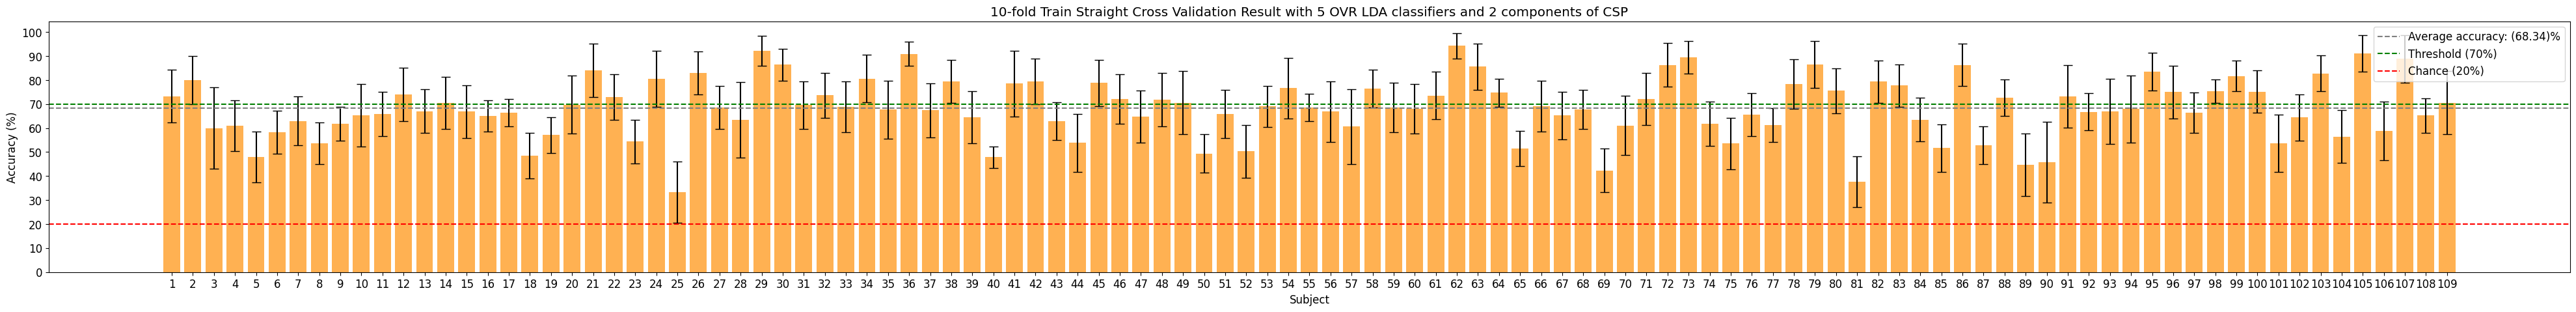

In [ ]:
from sklearn.multiclass import OneVsRestClassifier as OVR

clf = OVR(LDA(solver = 'svd'))
kfold = 10

all_cross_val_scores = np.zeros((len(all_comp), len(perSubj_train_feat_vect),2))
mean_cross_val_scores = np.zeros((len(all_comp),2))

all_shuffled_test_labels = []
all_test = []

for count, n_comp in enumerate(all_comp):

  cross_val_scores = np.zeros((len(perSubj_train_feat_vect),2))

  test_labels=[]
  test=[]

  for subject in range(len(perSubj_train_feat_vect)):

    X_train = all_subject_comp_fselect_train[subject][count][:, 0:k_feat]
    X_test = all_subject_comp_fselect_test[subject][count]

    y_train = all_subject_comp_fselect_train[subject][count][:, k_feat].reshape(-1,1)
    y_test = all_test_labels[subject][count][0].reshape(-1,1)

    train = np.concatenate((X_train,y_train), axis = 1)
    test.append(np.concatenate((X_test,y_test), axis = 1))

    np.random.shuffle(train) # Randomiza a ordem
    np.random.shuffle(test[subject])

    # Perform cross-validation on train data with LDA classifier (Tuning hyperparameters)
    scores = cross_val_score(clf, train[:,0:k_feat], train[:,k_feat], cv=kfold)

    # Fit the LDA classifier on the entire train dataset (Model training)
    clf.fit(train[:,0:k_feat], train[:,k_feat])

    # Predict the target classes for test dataset
    test_labels.append(clf.predict(test[subject][:,0:k_feat]))
  
    cross_val_scores[subject,0] = (scores.mean() * 100)
    cross_val_scores[subject,1] = (scores.std() * 100)

    #print("Acuracia (Cross-validation) do participante %d: %0.2f (+/- %0.2f)" % (subject+1, cross_val_scores[subject,0], cross_val_scores[subject,1]))

  #print("Média de acuracia (Cross-validation) com %d componentes: %0.2f (+/- %0.2f) " % (n_comp,np.mean(cross_val_scores[:,0]), np.mean(cross_val_scores[:,1])))

  all_cross_val_scores[count] = cross_val_scores

  all_test.append(test)
  all_shuffled_test_labels.append(test_labels)

  mean_cross_val_scores[count,0] = np.mean(cross_val_scores[:,0])
  mean_cross_val_scores[count,1] = np.mean(cross_val_scores[:,1])

idx = np.argmax(mean_cross_val_scores[:,0]) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(perSubj_train_feat_vect)+1), all_cross_val_scores[idx][:,0], color="#ffb152", yerr=all_cross_val_scores[idx][:,1], capsize=5)
ax.axhline(y=np.mean(all_cross_val_scores[idx][:,0]), color='grey', linestyle='--', label = f'Average accuracy: ({np.mean(all_cross_val_scores[idx][:,0]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(perSubj_train_feat_vect)+1), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'10-fold Train Straight Cross Validation Result with 5 OVR LDA classifiers and {idx+1} components of CSP');
ax.legend();

### **LDA - Teste**

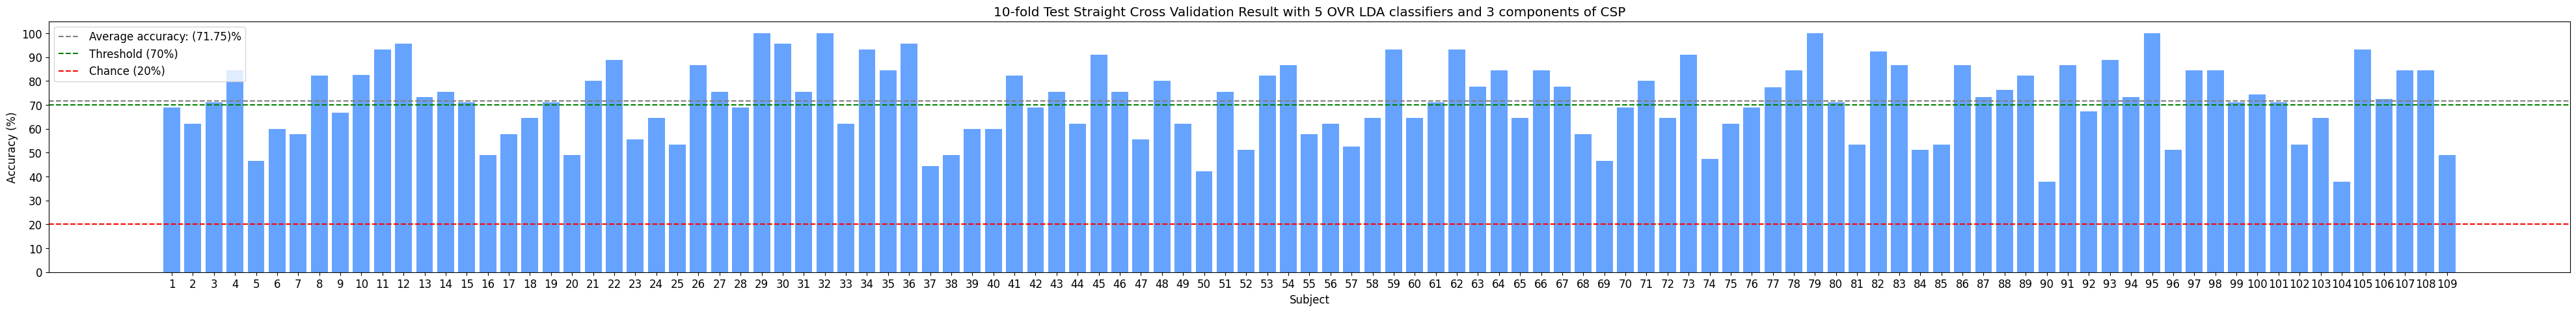

In [ ]:
all_acc_comp = np.zeros((len(all_comp),len(perSubj_train_feat_vect)))
mean_acc = np.zeros((len(all_comp),1))

for count, n_comp in enumerate(all_comp):

  all_acc = np.zeros(len(perSubj_train_feat_vect))

  for subject in range(len(perSubj_train_feat_vect)):

    acc = accuracy_score(all_test[count][subject][:,k_feat],all_shuffled_test_labels[count][subject]) * 100
    all_acc[subject] = acc 

    #print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

  mean_acc[count] = np.mean(all_acc)
  all_acc_comp[count,:] = all_acc

idx = np.argmax(mean_acc) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(perSubj_train_feat_vect)+1), all_acc_comp[idx], color="#66a3ff", capsize=5)
ax.axhline(y=np.mean(all_acc_comp[idx]), color='grey', linestyle='--', label = f'Average accuracy: ({np.mean(all_acc_comp[idx]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(perSubj_train_feat_vect)+1), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'{kfold}-fold Test Straight Cross Validation Result with 5 OVR LDA classifiers and {idx+1} components of CSP');
ax.legend();

### **SVM - Treino**

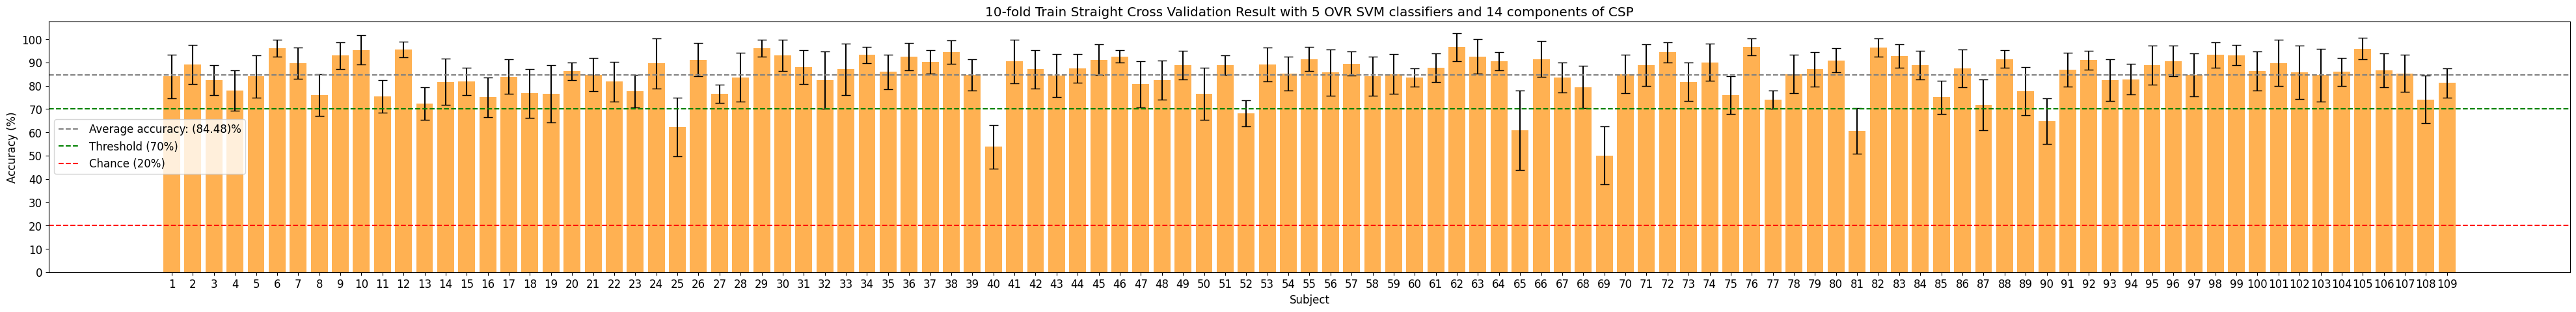

In [ ]:
clf = OVR(SVC(kernel='rbf'))
kfold = 10

all_cross_val_scores = np.zeros((len(all_comp), len(perSubj_train_feat_vect),2))
mean_cross_val_scores = np.zeros((len(all_comp),2))

all_shuffled_test_labels = []
all_test = []

for count, n_comp in enumerate(all_comp):

  cross_val_scores = np.zeros((len(perSubj_train_feat_vect),2))

  test_labels=[]
  subj_test=[]

  for subject in range(len(perSubj_train_feat_vect)):

    X_train = all_subject_comp_fselect_train[subject][count][:, 0:k_feat]
    X_test = all_subject_comp_fselect_test[subject][count]

    y_train = all_subject_comp_fselect_train[subject][count][:, k_feat].reshape(-1,1)
    y_test = all_test_labels[subject][count][0].reshape(-1,1)

    train = np.concatenate((X_train,y_train), axis = 1)
    test = np.concatenate((X_test,y_test), axis = 1)

    subj_test.append(test)

    np.random.shuffle(train) # Randomiza a ordem
    np.random.shuffle(test)
    
    # Perform cross-validation on train data with LDA classifier (Tuning hyperparameters)
    scores = cross_val_score(clf, train[:,0:k_feat], train[:,k_feat], cv=kfold)

    # Fit the LDA classifier on the entire train dataset (Model training)
    clf.fit(train[:,0:k_feat], train[:,k_feat])

    # Predict the target classes for test dataset
    test_labels.append(clf.predict(test[:,0:k_feat]))
  
    cross_val_scores[subject,0] = (scores.mean() * 100)
    cross_val_scores[subject,1] = (scores.std() * 100)

    #print("Acuracia (Cross-validation) do participante %d: %0.2f (+/- %0.2f)" % (subject+1, cross_val_scores[subject,0], cross_val_scores[subject,1]))

  #print("Média de acuracia (Cross-validation) com %d componentes: %0.2f (+/- %0.2f) " % (n_comp,np.mean(cross_val_scores[:,0]), np.mean(cross_val_scores[:,1])))

  all_cross_val_scores[count] = cross_val_scores

  all_test.append(subj_test)
  all_shuffled_test_labels.append(test_labels)

  mean_cross_val_scores[count,0] = np.mean(cross_val_scores[:,0])
  mean_cross_val_scores[count,1] = np.mean(cross_val_scores[:,1])

idx = np.argmax(mean_cross_val_scores[:,0]) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(perSubj_train_feat_vect)+1), all_cross_val_scores[idx][:,0], color="#ffb152", yerr=all_cross_val_scores[idx][:,1], capsize=5)
ax.axhline(y=np.mean(all_cross_val_scores[idx][:,0]), color='grey', linestyle='--', label = f'Average accuracy: ({np.mean(all_cross_val_scores[idx][:,0]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(perSubj_train_feat_vect)+1), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'{kfold}-fold Train Straight Cross Validation Result with 5 OVR SVM classifiers and {idx+1} components of CSP');
ax.legend();

### **SVM - Teste**

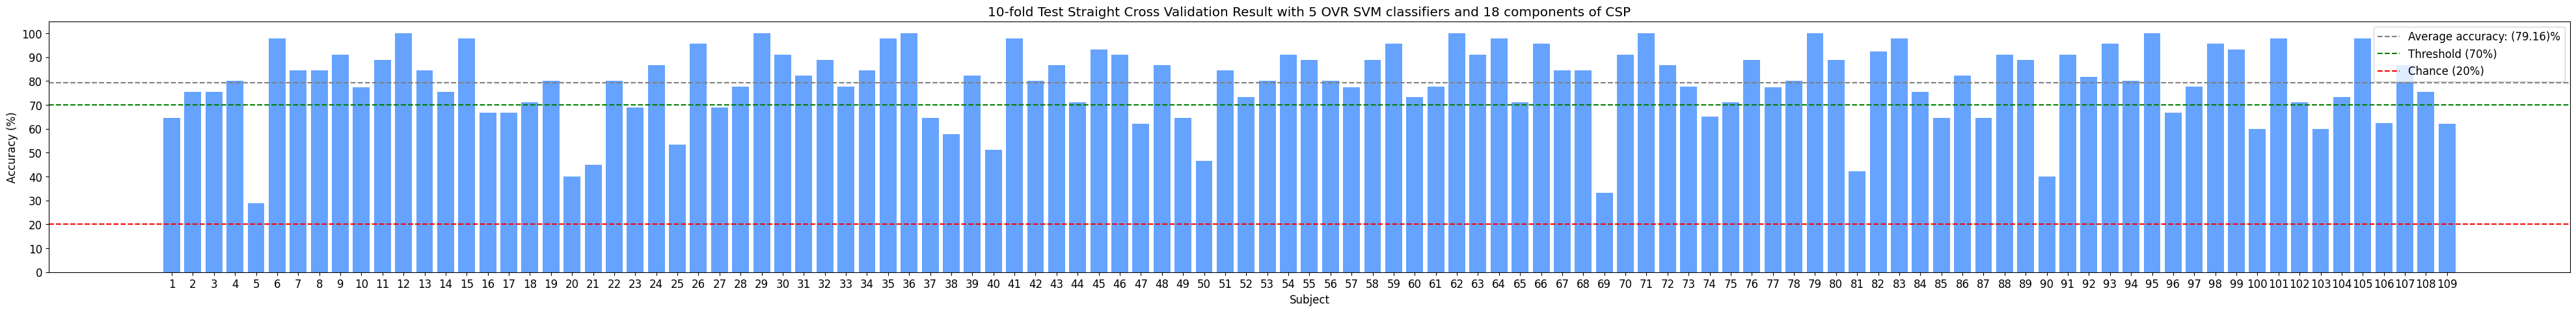

In [ ]:
all_acc_comp = np.zeros((len(all_comp),len(perSubj_train_feat_vect)))
mean_acc = np.zeros((len(all_comp),1))

for count, n_comp in enumerate(all_comp):

  all_acc = np.zeros(len(perSubj_train_feat_vect))

  for subject in range(len(perSubj_train_feat_vect)):

    acc = accuracy_score(all_test[count][subject][:,k_feat],all_shuffled_test_labels[count][subject]) * 100
    all_acc[subject] = acc 

    #print("Acuracia do participante %d: %0.2f " % (subject+1, acc))

  mean_acc[count] = np.mean(all_acc)
  all_acc_comp[count,:] = all_acc

idx = np.argmax(mean_acc) # Indice da melhor acuracia

fig, ax = plt.subplots(figsize=(50, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, len(perSubj_test_feat_vect)+1), all_acc_comp[idx], color="#66a3ff", capsize=5)
ax.axhline(y=np.mean(all_acc_comp[idx]), color='grey', linestyle='--', label = f'Average accuracy: ({np.mean(all_acc_comp[idx]):.2f})%')
ax.axhline(y=70, color='green', linestyle='--', label = 'Threshold (70%)')
ax.axhline(y=20, color='red', linestyle='--', label = 'Chance (20%)')
ax.set(xticks=np.arange(1, len(perSubj_test_feat_vect)+1), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy (%)',
       title=f'{kfold}-fold Test Straight Cross Validation Result with 5 OVR SVM classifiers and {idx+1} components of CSP');
ax.legend();